In [1]:
from utils.model import light
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn

# 检查设备信息
light.DeviceUtils.print_device_info()

🔍 设备检测结果:
   PyTorch版本: 2.7.1+cu128
   CUDA: ❌
   MPS (Apple Silicon): ❌
   推荐设备: cpu


In [5]:
from torch._tensor import Tensor


class LeNet(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(
                16,
                kernel_size=5,
            ),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(config.output_size),
        )

    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)

    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


datapath = "../../data/"

In [6]:
color_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10的RGB均值
            std=[0.2023, 0.1994, 0.2010],  # CIFAR-10的RGB标准差
        ),
    ]
)
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=color_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=color_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")

CIFAR-10 数据集类别数: 10
类别名称: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
训练集大小: 50000
测试集大小: 10000


In [7]:
# 创建配置
config = light.ModelConfig(
    lr=0.001,  # 较小的学习率
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",  # Adam优化器更适合彩色图像
    weight_decay=1e-4,  # 正则化
)

# 创建模型
model_color_lenet = LeNet(config)



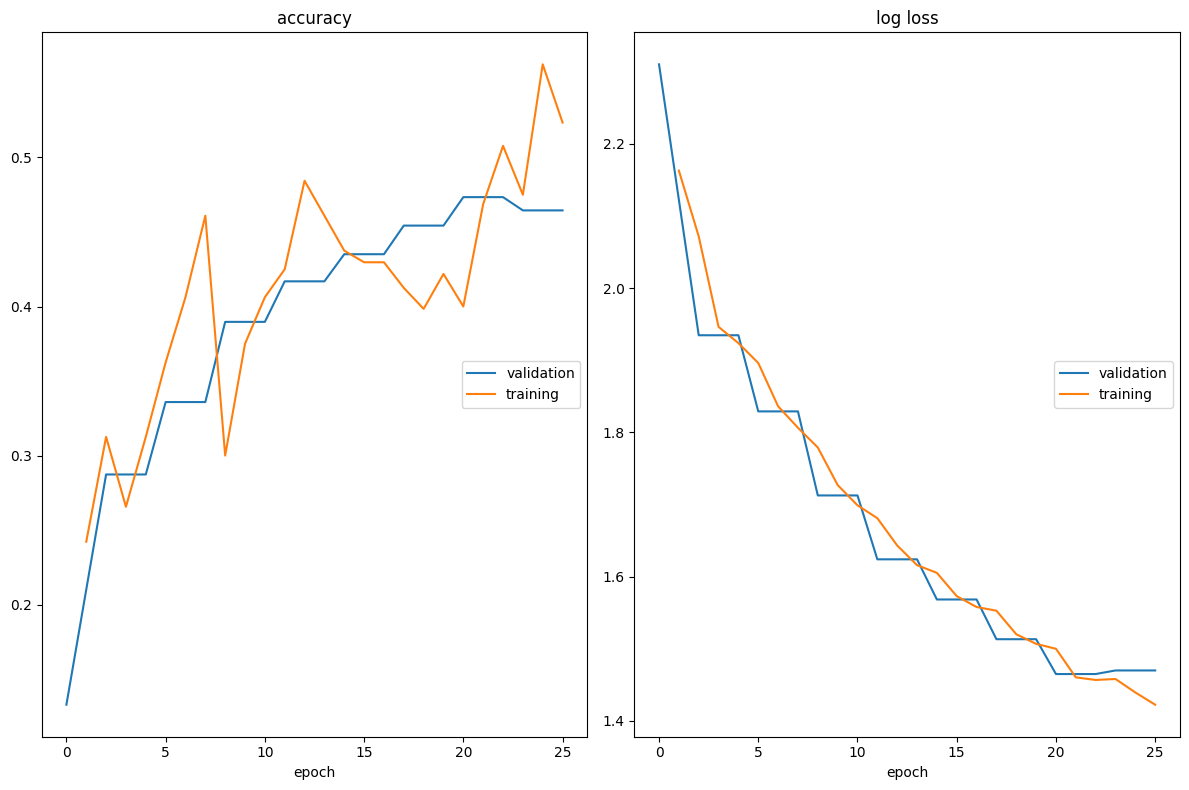

accuracy
	validation       	 (min:    0.133, max:    0.473, cur:    0.465)
	training         	 (min:    0.242, max:    0.562, cur:    0.523)
log loss
	validation       	 (min:    1.465, max:    2.310, cur:    1.470)
	training         	 (min:    1.423, max:    2.163, cur:    1.423)
Epoch 8:  99%|█████████▉| 388/391 [00:24<00:00, 15.92it/s, v_num=2, train_loss=1.410, train_acc=0.500, val_loss=1.470, val_acc=0.465]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [8]:
trainer_color_lenet = light.TrainerFactory.basic(max_epochs=20)
trainer_color_lenet.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=200)
)
print("🚀 开始训练彩色 LeNet..."
      )
trainer_color_lenet.fit(model_color_lenet, train_loader, val_loader)

In [6]:
from torch._tensor import Tensor

class BetterLeNet(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 使用MaxPool代替AvgPool
            nn.LazyConv2d(
                16,
                kernel_size=5,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(config.output_size),
        )

    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)

    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


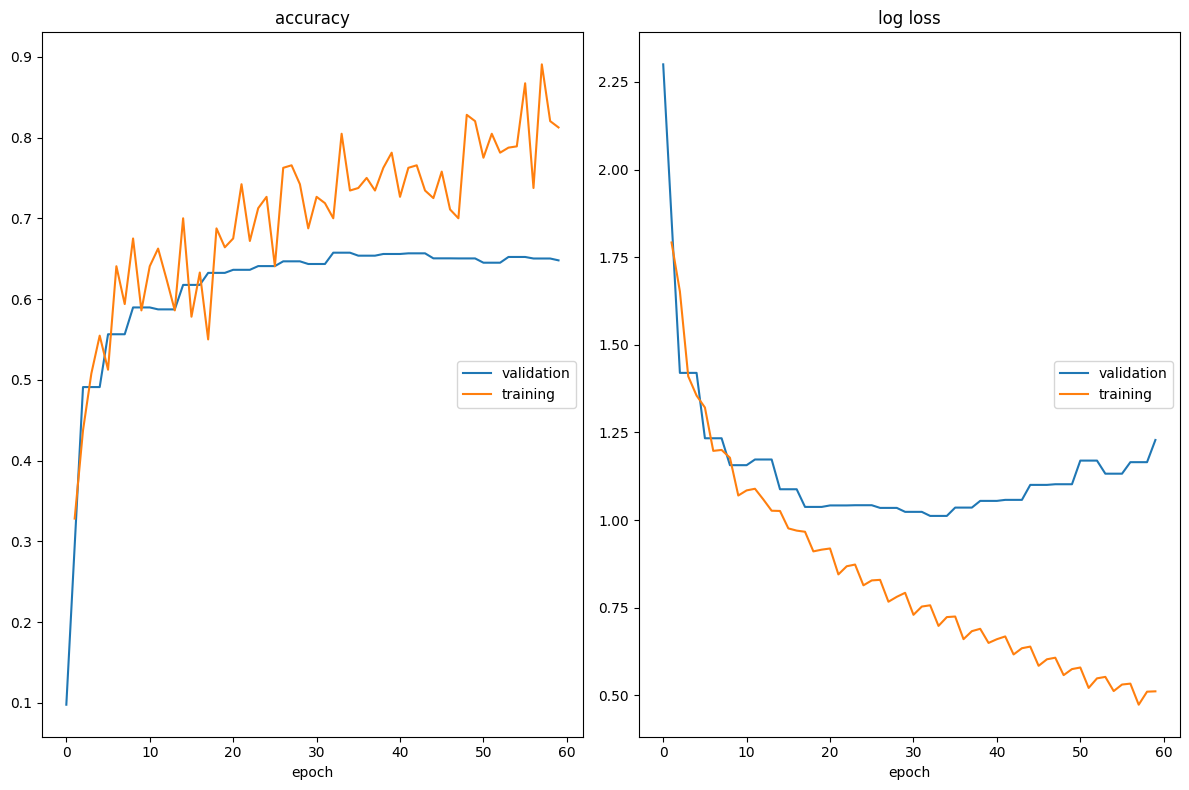

accuracy
	validation       	 (min:    0.098, max:    0.657, cur:    0.648)
	training         	 (min:    0.328, max:    0.891, cur:    0.812)
log loss
	validation       	 (min:    1.012, max:    2.300, cur:    1.228)
	training         	 (min:    0.473, max:    1.792, cur:    0.511)
Epoch 19: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s, v_num=23, train_loss=0.494, train_acc=0.812, val_loss=1.230, val_acc=0.648]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s, v_num=23, train_loss=0.494, train_acc=0.812, val_loss=1.230, val_acc=0.648]


In [7]:
datapath = "../../data/"
color_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10的RGB均值
            std=[0.2023, 0.1994, 0.2010],  # CIFAR-10的RGB标准差
        ),
    ]
)
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=color_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=color_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")

# 创建配置
config = light.ModelConfig(
    lr=0.001,  # 较小的学习率
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",  # Adam优化器更适合彩色图像
    weight_decay=1e-4,  # 正则化
)

# 创建模型
model_color_lenet = BetterLeNet(config)

trainer_color_lenet = light.TrainerFactory.basic(max_epochs=20)
trainer_color_lenet.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=200)
)
print("🚀 开始训练彩色 LeNet..."
      )
trainer_color_lenet.fit(model_color_lenet, train_loader, val_loader)

In [8]:
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, cardinality=32):
        super().__init__()
        width = out_channels // 2
        
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, width, 1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),
            nn.Conv2d(width, width, 3, stride, 1, groups=cardinality, bias=False),
            nn.BatchNorm2d(width), 
            nn.ReLU(inplace=True),
            nn.Conv2d(width, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.main_path(x) + self.shortcut(x))

class ResNeXt(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        
        # 初始层
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        
        # ResNeXt层 - 这里不能用Sequential包含ResNeXtBlock
        self.layer1 = ResNeXtBlock(64, 64, 1, 32)
        self.layer2 = ResNeXtBlock(64, 128, 2, 32)
        self.layer3 = ResNeXtBlock(128, 256, 2, 32)
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(256, config.output_size)
        )
    
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)  # 必须逐个调用
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)
    
    def compute_loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)
    
    def predict_class(self, x):
        return self.predict(x).item()
    
    def evaluate(self, X, y):
        with torch.no_grad():
            y_hat = self.forward(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }

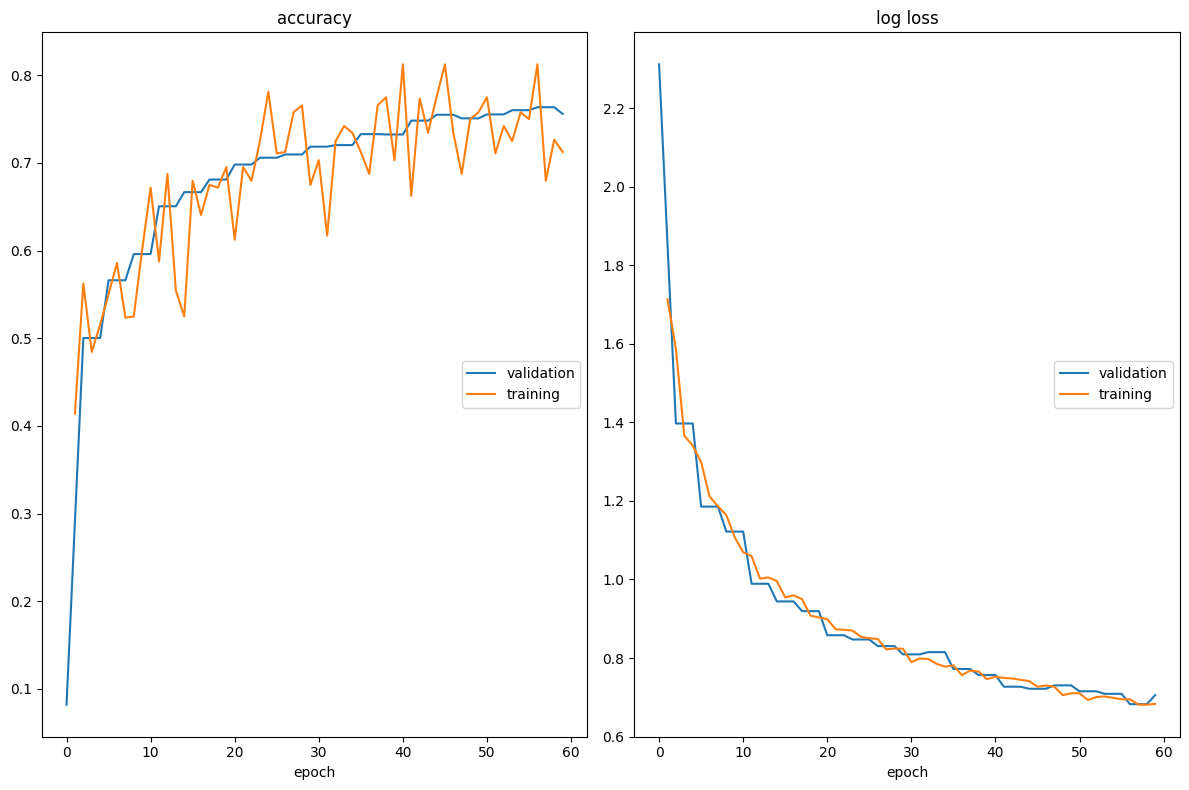

accuracy
	validation       	 (min:    0.082, max:    0.764, cur:    0.756)
	training         	 (min:    0.414, max:    0.812, cur:    0.713)
log loss
	validation       	 (min:    0.682, max:    2.312, cur:    0.706)
	training         	 (min:    0.681, max:    1.714, cur:    0.683)
Epoch 19: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s, v_num=25, train_loss=0.689, train_acc=0.713, val_loss=0.706, val_acc=0.756]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s, v_num=25, train_loss=0.689, train_acc=0.713, val_loss=0.706, val_acc=0.756]


In [10]:
datapath = "../../data/"
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=train_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=test_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")

# 创建配置
config = light.ModelConfig(
    lr=0.001,  # 较小的学习率
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",  # Adam优化器更适合彩色图像
    weight_decay=1e-4,  # 正则化
    dropout_rate=0.1,  # Dropout正则化
)

# 创建模型
model_color_ResNeXt = ResNeXt(config)

trainer_color_ResNeXt = light.TrainerFactory.basic(max_epochs=20)
trainer_color_ResNeXt.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=200)
)
print("🚀 开始训练彩色 ResNeXt..."
      )
trainer_color_ResNeXt.fit(model_color_ResNeXt, train_loader, val_loader)

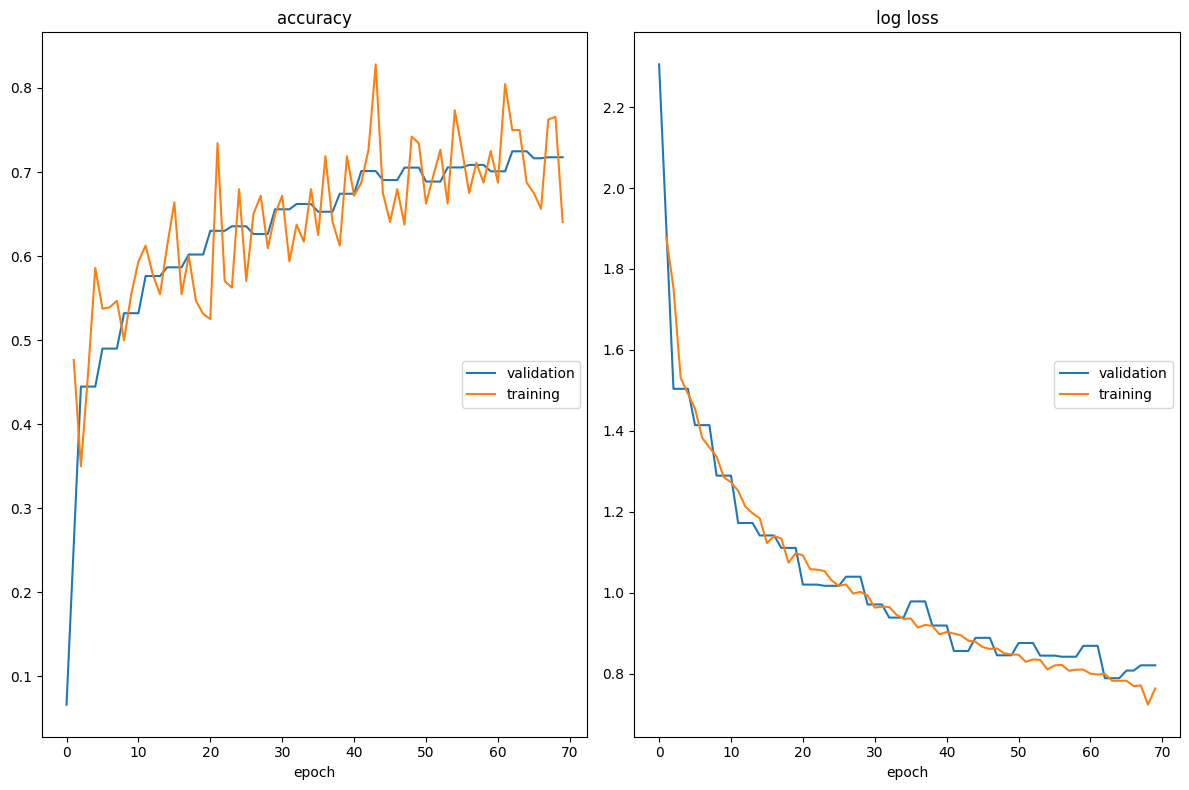

accuracy
	validation       	 (min:    0.066, max:    0.725, cur:    0.718)
	training         	 (min:    0.350, max:    0.828, cur:    0.641)
log loss
	validation       	 (min:    0.789, max:    2.306, cur:    0.821)
	training         	 (min:    0.723, max:    1.878, cur:    0.764)
Epoch 23:  85%|████████▌ | 333/391 [00:23<00:04, 14.12it/s, v_num=28, train_loss=0.771, train_acc=0.711, val_loss=0.821, val_acc=0.718]

MemoryError: 

In [14]:
datapath = "../../data/"
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=train_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=test_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")

# 创建配置
config = light.ModelConfig(
    lr=0.05,  # 较小的学习率
    num_hiddens=256,
    output_size=num_classes,
    optimizer="sgd",  # SGD优化器
    weight_decay=1e-4,  # 正则化
    dropout_rate=0.1,  # Dropout正则化
    momentum=0.9,  # SGD动量
)

# 创建模型
model_color_ResNeXt_sgd = ResNeXt(config)

trainer_color_ResNeXt = light.TrainerFactory.basic(max_epochs=30)
trainer_color_ResNeXt.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=200)
)
print("🚀 开始训练彩色 ResNeXt..."
      )
trainer_color_ResNeXt.fit(model_color_ResNeXt_sgd, train_loader, val_loader)

In [12]:
class ResNeXt_Better(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True

        # 初始层
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # ResNeXt层 - 这里不能用Sequential包含ResNeXtBlock
        self.layer1 = self.make_stage(64, 128, 1, 32, 2)  # 输出分辨率不变
        self.layer2 = self.make_stage(128, 256, 2, 32, 2) # 下采样
        self.layer3 = self.make_stage(256, 512, 2, 32, 2) # 下采样


        # 分类器
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(512, config.output_size),
        )

    def make_stage(self, in_c, out_c, stride, cardinality, blocks):
        layers = [ResNeXtBlock(in_c, out_c, stride, cardinality)]
        for _ in range(1, blocks):
            layers.append(ResNeXtBlock(out_c, out_c, 1, cardinality))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)  # 必须逐个调用
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)

    def compute_loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x):
        return self.forward(x).argmax(dim=1)

    def predict_class(self, x):
        return self.predict(x).item()

    def evaluate(self, X, y):
        with torch.no_grad():
            y_hat = self.forward(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }

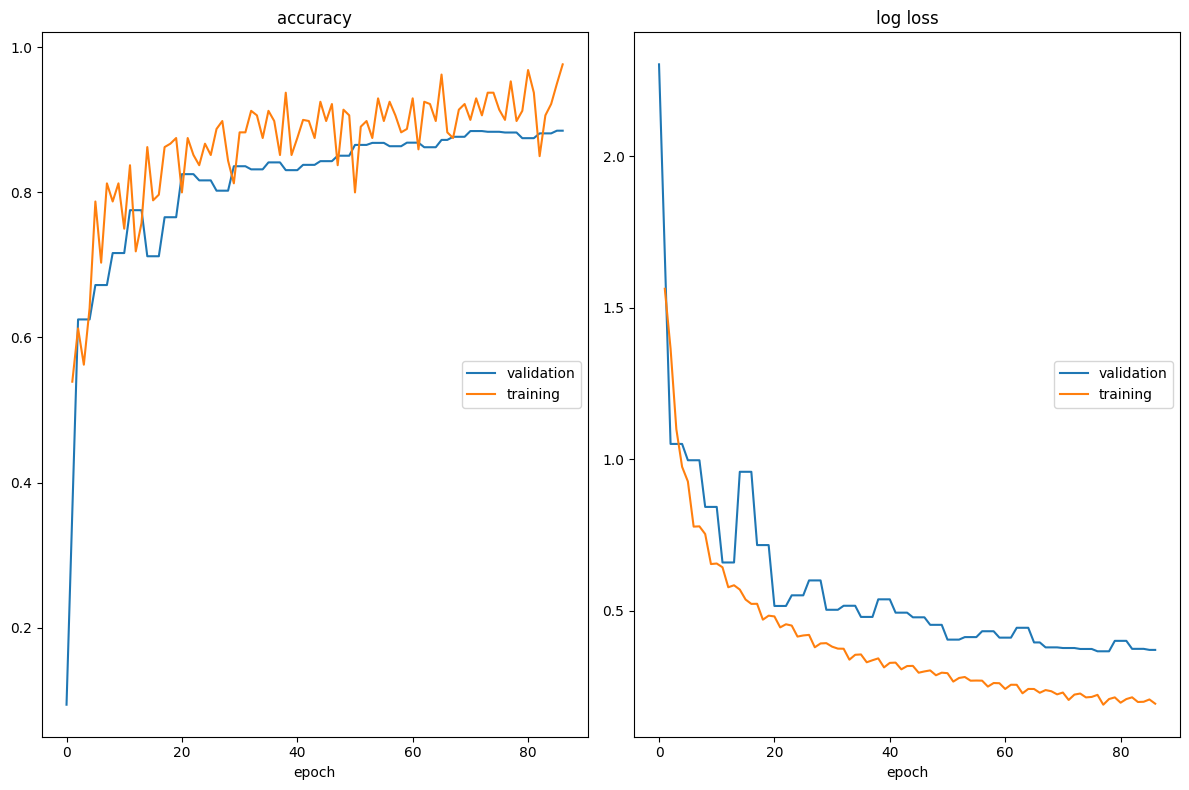

accuracy
	validation       	 (min:    0.094, max:    0.885, cur:    0.885)
	training         	 (min:    0.539, max:    0.977, cur:    0.977)
log loss
	validation       	 (min:    0.366, max:    2.304, cur:    0.370)
	training         	 (min:    0.189, max:    1.563, cur:    0.193)
Epoch 29:  59%|█████▉    | 232/391 [00:40<00:27,  5.72it/s, v_num=27, train_loss=0.289, train_acc=0.906, val_loss=0.370, val_acc=0.885] 

MemoryError: 

In [13]:
datapath = "../../data/"
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=train_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=test_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")

# 创建配置
config = light.ModelConfig(
    lr=0.001,  # 较小的学习率
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",  # Adam优化器
    weight_decay=1e-4,  # 正则化
    dropout_rate=0.15,  # Dropout正则化
)

# 创建模型
model_color_ResNeXt_better = ResNeXt_Better(config)

trainer_color_ResNeXt = light.TrainerFactory.basic(max_epochs=30)
trainer_color_ResNeXt.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=200)
)
print("🚀 开始训练彩色 ResNeXt..."
      )
trainer_color_ResNeXt.fit(model_color_ResNeXt_better, train_loader, val_loader)